In [1]:
import numpy as np
import matplotlib.pyplot as plt

# La regresión logística

Vamos a desarrollar de manera completamente teórica el problema en con una y dos variables (features).

Primero definiremos, como en el caso de la regresión lineal las diferentes funciones necesarias.

In [2]:
def sigmoid(x):
    '''función sigmoide que sirve para determinar las clases '''
    return 1/(1+np.exp(-x))

def loss(y, y_hat):
    '''
    función que computa la función de pérdida. 
    y: valores predichos por el modelo
    y_hat: valores verdaderos
    ''' 
    eps = 1e-10
    return -np.mean(y_hat*np.log(y + eps) + (1-y_hat)*np.log(1 - y + eps))

def dloss(a, b, x, y_hat):
    '''
    Gradiente de la función de pérdida
    da: derivada en la direccion de a
    db: derivada en la direccion de b
    '''
    da = np.mean((sigmoid(a*x+b)-y_hat)*x)
    db = np.mean(sigmoid(a*x+b)-y_hat)
    return da, db

def train(x, y_hat, epochs = 10, a = 0, b = 0, lr = 0.2):
    '''
    Funcion que entrena al modelo encontrando los valores optimos de los parametros (a y b)
    x: valor de entrada de la variable (feature)
    y_hat: valor verdadero de la funcion en x
    epochs: numero de veces que se recorrera todo el set de datos
    lr: tasa de aprendizaje (learning rate)
    '''
    grad = dloss(a,b,x,y_hat)   # calculo del gradiente para el paso cero
    history = [[a,b, grad[0], grad[1], loss(sigmoid(a*x+b),y_hat)]] # guardo los valores para observar el entrenamiento
    for i in range(epochs):
        grad = dloss(a,b,x,y_hat)   # calculo del gradiente para todo el conjunto de datos
        a -= lr * grad[0]        # paso de descenso por el gradiente
        b -=  lr * grad[1]        # paso de descenso por el gradiente
        history.append([a,b, grad[0], grad[1], loss(sigmoid(a*x+b),y_hat)])  # guardo la historia
    return a,b, history

## Ejemplo unidimensional

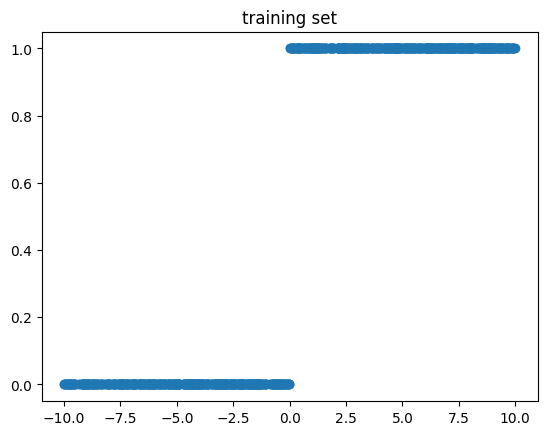

valores optimos: (7.808010676262771, 0.061006179191430525)


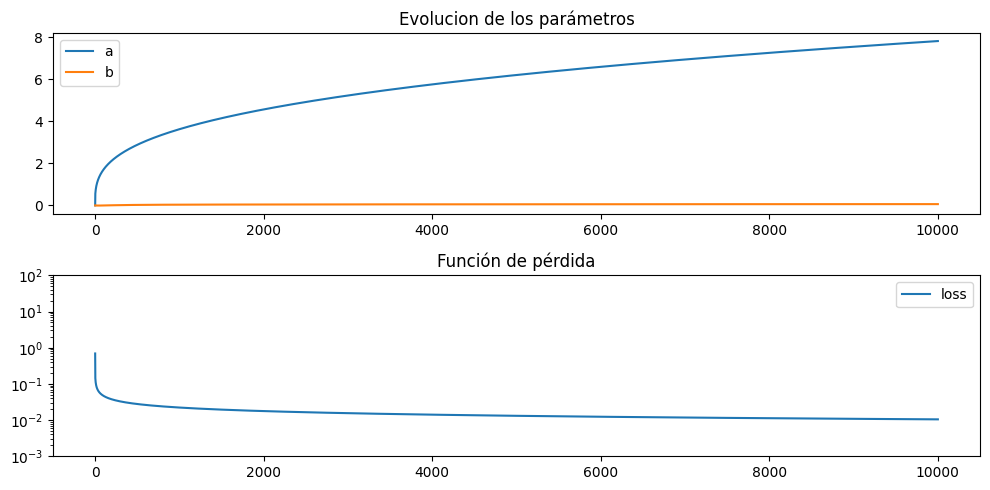

In [3]:
# Generando un conjunto de datos sintéticos
rng = np.random.default_rng() 
x_train = rng.uniform(-10,10,1000)
y_train = np.int32(sigmoid(x_train)+0.5)
plt.title('training set')
plt.scatter(x_train,y_train)
plt.show()

# Ajustando el modelo
a_opt,b_opt,hist = train(x_train, y_train, epochs= 10000)
print(f'valores optimos: {a_opt, b_opt}')
hist = np.array(hist)
fig, axs = plt.subplots(2,1, figsize = (10,5))
axs[0].set_title('Evolucion de los parámetros')
axs[0].plot(hist[:,0], label='a')
axs[0].plot(hist[:,1], label = 'b')
axs[0].legend()
axs[1].set_title('Función de pérdida')
axs[1].semilogy(hist[:,4], label = 'loss')
axs[1].set_ylim(1e-3,100)
axs[1].legend()
fig.tight_layout()

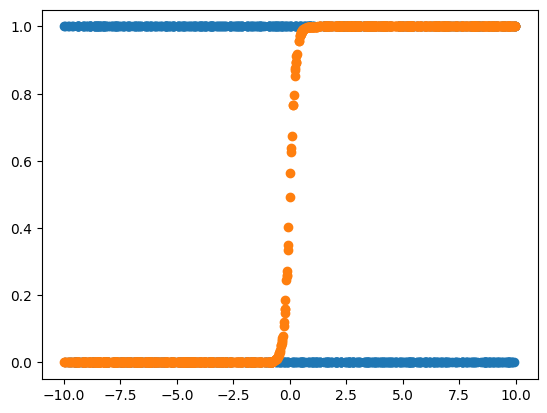

In [4]:
# viendo el funcionamiento del modelo
x_train = rng.uniform(-10,10,1000)
plt.plot(x_train, y_train, 'o')
plt.plot(x_train,sigmoid(a_opt*x_train+b_opt), 'o')

Finalmente la predicción para un valor de $x$ particular se realiza calculando la función sigmoide con los parámetros óptimos en el valor requerido

In [5]:
def circle(nx : int, ny: int, rad: int):
    '''funcion para construir circulos'''
    assert rad < min(nx,ny), 'el circulo debe estar completamente dentro'
    canvas = np.zeros(shape=(nx,ny))
    for i in range(nx):
        for j in range(ny):
            if ((i-nx//2)**2 + (j-ny//2)**2 < rad**2):
                canvas[i,j] = 1
    return canvas    

def square(nx : int, ny: int, length: int):
    '''funcion para construir cuadradillos'''
    assert length < min(nx,ny)
    canvas = np.ones(shape=(nx,ny))
    for i in range(nx):
        for j in range(ny):
            if (np.abs(i-nx//2) > length) or (np.abs(j-ny//2) > length):
                canvas[i,j] = 0
    return canvas    

# Clasificacion mediante regresion logistica

Vamos a generar un conjunto de datos artificiales que consistiran en imagenes en 1 bit de 51x51 pixeles con cuadrados y circulos de diferentes tamaños centrados. Vamos a utilizar la librería __Sci-kit learn__ que provee una librería para regresiones muy potente

In [6]:
nx = 51
ny = 51

In [7]:
# creacion del dataset. Asignamos 0 a los circulos y 1 a los cuadrados

rng = np.random.default_rng()
y_train = rng.integers(0,2,200)
x_train = []
for i in y_train:
    if i == 0:
        x_train.append(circle(nx, ny, rng.integers(1,25)))
    else:
        x_train.append(square(nx, ny, rng.integers(1,25)))

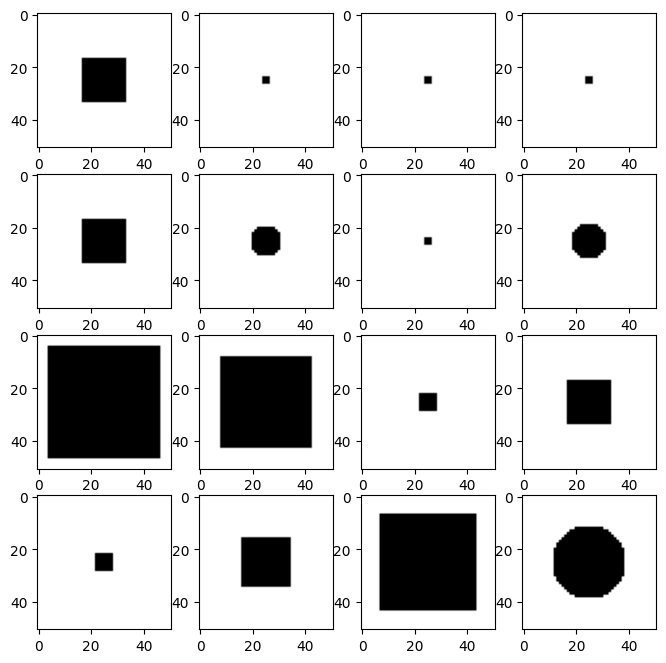

In [8]:
# examinamos algunos casos ocularmente

fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    img = rng.choice(x_train)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='Greys')
plt.show()

En primer lugar vamos a utilizar un modelo con reducción de dimensionalidad. Intentaremos reducir el problema tomando como variables el área y la distancia horizontal desde el centro

In [9]:
def reduce_train(x_t):
    # como las imagenes son en 1 bit, basta con sumar los 1 para tener el area
    area_train = [x.sum() for x in x_t]
    diametro_train = [x[nx//2,:].sum() for x in x_t]
    return np.vstack([diametro_train,area_train]).T

x = reduce_train(x_train)
x.shape

(200, 2)

In [10]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression(penalty='l2', solver='liblinear',max_iter=1000)
reg.fit(x,y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [11]:
# Atributos del modelo
print(f'numero de variables {reg.n_features_in_}')
print(f'numero de clases: {reg.classes_}')
print(f'valor de los coeficientes: {reg.coef_}')
print(f'valor del bias: {reg.intercept_}')

numero de variables 2
numero de clases: [0 1]
valor de los coeficientes: [[-0.17341187  0.00405122]]
valor del bias: [1.4767121]


(0.0, 2500.0)

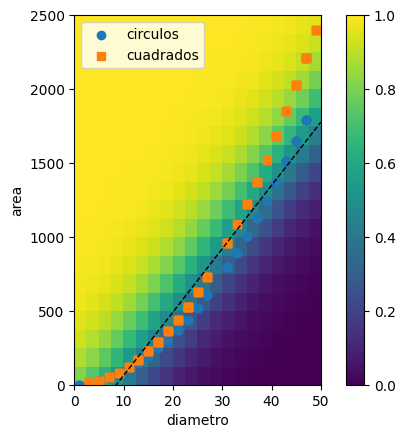

In [12]:
x_plot = np.array([[i,j] for i in np.linspace(0,50,20) for j in np.linspace(0,2500,20)])
f_plot = sigmoid(reg.decision_function(x_plot))
plt.imshow(f_plot.reshape(20,20).T, origin='lower', extent=[0,50,0,2500], aspect=0.03, interpolation='None')
plt.scatter(x[y_train==0, 0],x[y_train==0, 1],marker='o', label= 'circulos')
plt.scatter(x[y_train==1, 0],x[y_train==1, 1],marker='s', label= 'cuadrados')
plt.xlabel('diametro')
plt.ylabel('area')
plt.legend()


# Retrieve the model parameters.
b = reg.intercept_[0]
w1, w2 = reg.coef_[0]
# Calculate the intercept and gradient of the decision boundary.
c = -b/w2
m = -w1/w2

# Plot the data and the classification with the decision boundary.
xmin, xmax = 0, 50
ymin, ymax = 0, 2500
xd = np.array([xmin, xmax])
yd = m*xd + c
plt.plot(xd, yd, 'k', lw=1, ls='--')
plt.colorbar()
plt.ylim(0,2500)

Claramente esta clasificación es mala.

## Análisis del conjunto de test y validación 
Normalmente para caracterizar un modelo, se suele realizar la siguiente distinción sobre el conjunto de datos

* training set: Conjunto de datos sobre el que se entrena el modelo
* test set: Conjunto sore el que se testea el modelo para chequear el comportamiento del ajuste. Normalmente una porción tomada al azar del training set
* validation set: Conjunto completamente independiente de los conjuntos previos sobre el cual se valida el modelo

Normalmente en un problema de clasificación se toman métricas sobre cada uno de los conjuntos previos. La métrica usual suele ser la llamada __accuracy__
que mide la distancia entre aciertos y desaciertos del clasificador.

In [13]:
from sklearn.metrics import accuracy_score

In [14]:
# Return the fraction of correctly classified samples (float)
# The best performance is 1 
# creacion de un conjunto de validación. Como antes, asignamos 0 a los circulos y 1 a los cuadrados
n_val = 30
y_val = rng.integers(0,2,n_val)
x_val = []
for i in y_val:
    if i == 0:
        x_val.append(circle(nx, ny, rng.integers(1,25)))
    else:
        x_val.append(square(nx, ny, rng.integers(1,25)))

x_val = reduce_train(x_val)
print(f'precision training set: {accuracy_score(y_train, reg.predict(x))}')
print(f'precision validation set: {accuracy_score(y_val, reg.predict(x_val))}')

precision training set: 0.58
precision validation set: 0.5666666666666667


## Fronteras no lineales. Expansión de las variables

Para intentar una mejora del clasificador, se realizará una expansión de las variables, tomando los productos de segundo orden entre las dos variables descritas

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
def expand_features(feat):
    return np.hstack([feat, feat**2, (feat[:,0]*feat[:,1]).reshape(-1,1)])

In [17]:
# Haciendo un split en train y test
x_tr, x_tst, y_tr, y_tst = train_test_split(x,y_train, test_size= 0.2)
# inventamos nuevas variables basadas en los cuadrados
x_tr_new = expand_features(x_tr)
x_tst_new = expand_features(x_tst)

In [18]:
# creamos un nuevo modelo que acepta las nuevas features
reg2 = LogisticRegression(max_iter=100)
reg2.fit(x_tr_new, y_tr)
# Atributos del modelo
print('----------- Detalles del modelo ---------')
print(f'numero de variables {reg2.n_features_in_}')
print(f'clases (categorias): {reg2.classes_}')
print(f'valor de los coeficientes: {reg2.coef_}')
print(f'valor del bias: {reg2.intercept_}')
# Return the fraction of correctly classified samples (float)
# The best performance is 1 
print('----------- Métricas --------------------')
print(f'precision training set: {accuracy_score(y_tr, reg2.predict(x_tr_new))}')
print(f'precision validation set: {accuracy_score(y_tst, reg2.predict(x_tst_new))}')

----------- Detalles del modelo ---------
numero de variables 5
clases (categorias): [0 1]
valor de los coeficientes: [[-6.03428789e-02  9.26137230e-01 -9.53685307e-01 -2.48615787e-04
   1.28583000e-02]]
valor del bias: [-0.0076894]
----------- Métricas --------------------
precision training set: 0.93125
precision validation set: 1.0


/home/sebastian/Documents/Codes/series-temporales-machine-learning/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Los resultados son evidentes. Además, al ver el valor absoluto de cada uno de los coeficientes, se observa que la primer variable al cuadrado tiene gran protagonismo.

Vamos a crear un conjunto de validación y graficar los datos y fronteras para comprender qué sucedio

In [19]:
# creacion de un conjunto de validación. Como antes, asignamos 0 a los circulos y 1 a los cuadrados
n_val = 30
y_val = rng.integers(0,2,n_val)
x_val = []
for i in y_val:
    if i == 0:
        x_val.append(circle(nx, ny, rng.integers(1,25)))
    else:
        x_val.append(square(nx, ny, rng.integers(1,25)))

x_val = reduce_train(x_val)
x_val = expand_features(x_val)
print('----------- Métricas --------------------')
print(f'precision sobre {n_val} samples del conjunto de validacion: {accuracy_score(y_val, reg2.predict(x_val))}')

----------- Métricas --------------------
precision sobre 30 samples del conjunto de validacion: 1.0


/tmp/ipykernel_1223052/2365010396.py:3: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


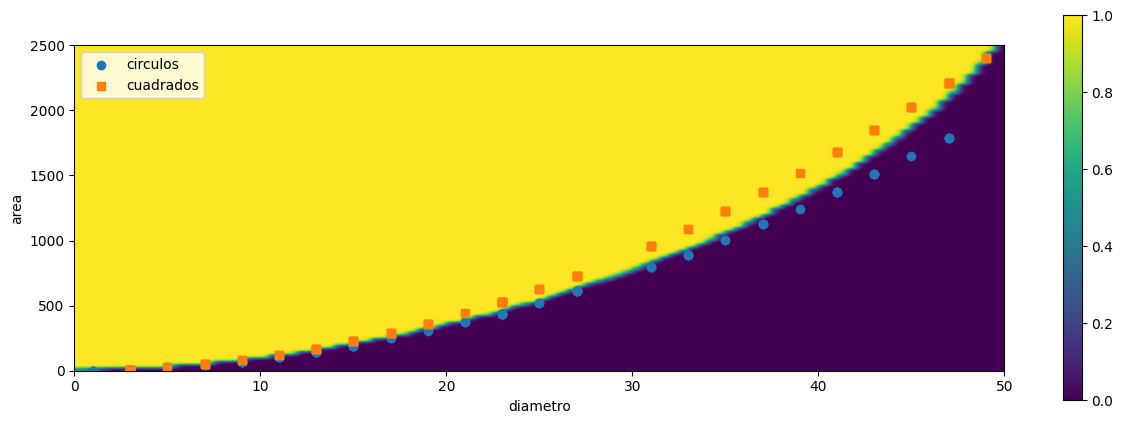

In [20]:
x_plot = np.array([[i,j,i**2,j**2,i*j] for i in np.linspace(0,50,100) for j in np.linspace(0,2500,100)])
f_plot = sigmoid(reg2.decision_function(x_plot))
plt.figure(figsize=(15,5))
plt.imshow(f_plot.reshape(100,100).T, origin='lower', extent=[0,50,0,2500], aspect=0.007, interpolation='gaussian')
plt.scatter(x_tr_new[y_tr==0, 0],x_tr_new[y_tr==0, 1],marker='o', label= 'circulos')
plt.scatter(x_tr_new[y_tr==1, 0],x_tr_new[y_tr==1, 1],marker='s', label= 'cuadrados')
plt.xlabel('diametro')
plt.ylabel('area')
plt.legend()
plt.colorbar()
plt.ylim(0,2500)
plt.show()

Al incluir variables cuadráticas, se permite a las fronteras tener curvas de segundo orden